In [8]:
from init import *
from src.process_data import read_initial_data
data_prefix = "C:\\Users\\kathl\Desktop\\Github\\ceds-cigar\\pycigar\\utils\\data_generation\\load\\data"
data = [data_prefix + '\\7_MWp_P.csv', data_prefix + '\\10_MWp_P.csv', data_prefix + '\\12_MWp_P.csv', data_prefix + '\\19_MWp_P.csv']
#new_file = [data_prefix + '\\LS\\Tran_bp_701_77073_5022.csv', data_prefix + '\\LS\\Tran_bp_701_77073_5025.csv', data_prefix + '\\LS\\Tran_bp_701_77073_5034.csv', data_prefix + '\\LS\\Tran_bp_701_77073_5035.csv']
new_file = [data_prefix + '\\LS\\Tran_dj_388104_1816_5022.csv', data_prefix + '\\LS\\Tran_dj_367162_1816_5025.csv', data_prefix + '\\LS\\Tran_dj_357546_1816_5025.csv', data_prefix + '\\LS\\Tran_dj_388082_1816_5024.csv']

# dss_kw = [0.14, 0.16, 0.18, 0.07, 0.09] #assumes input in kw
dss_kw = []
load_gen = LoadGenerator(new_file, dss_kw) 

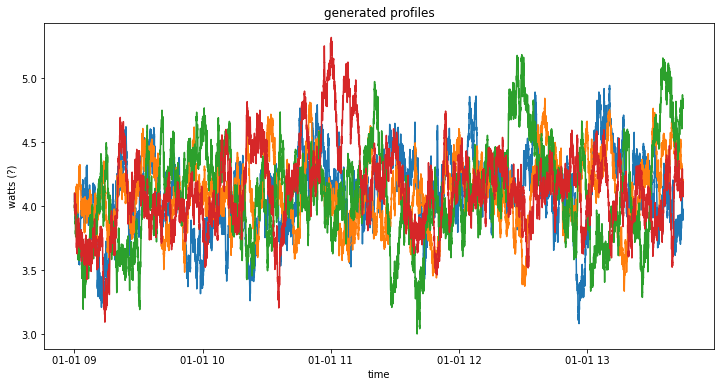

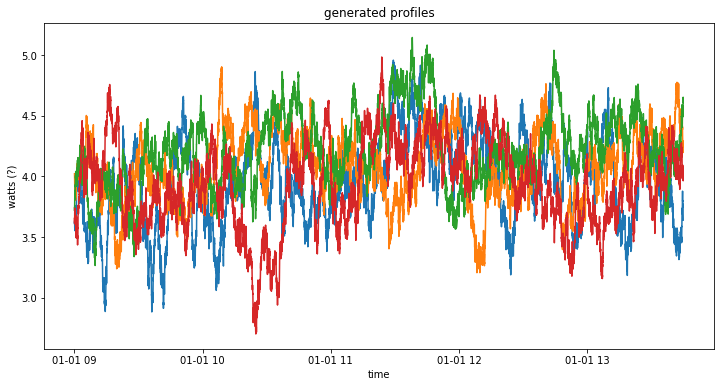

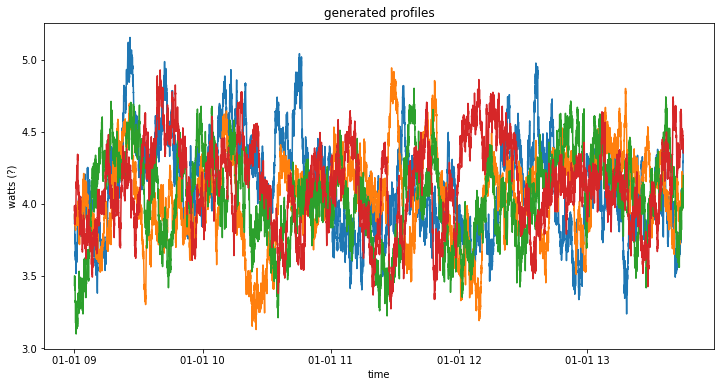

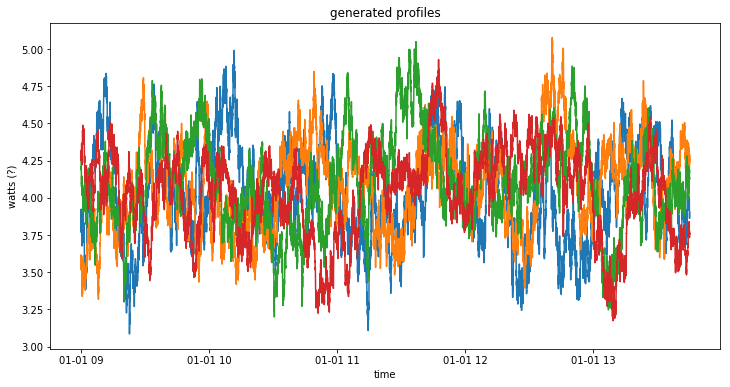

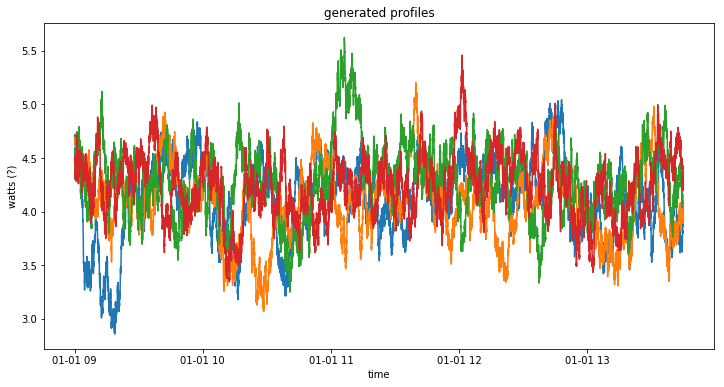

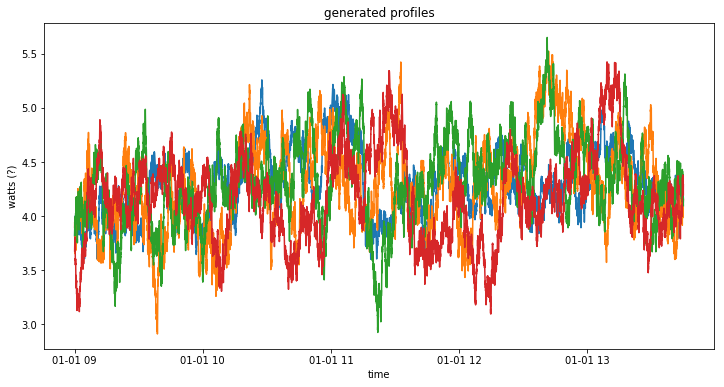

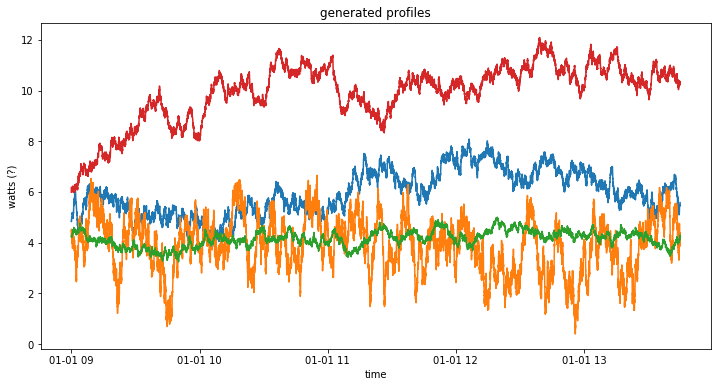

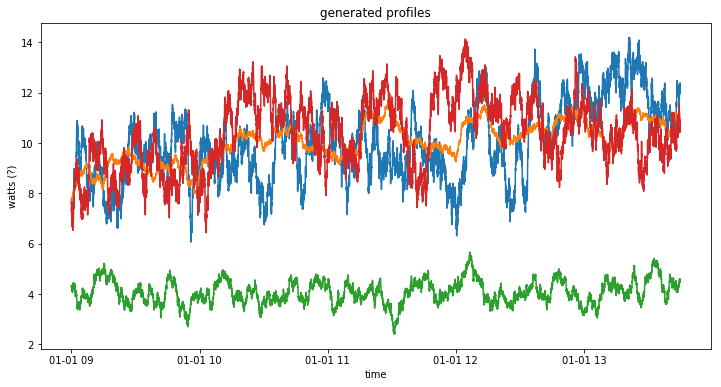

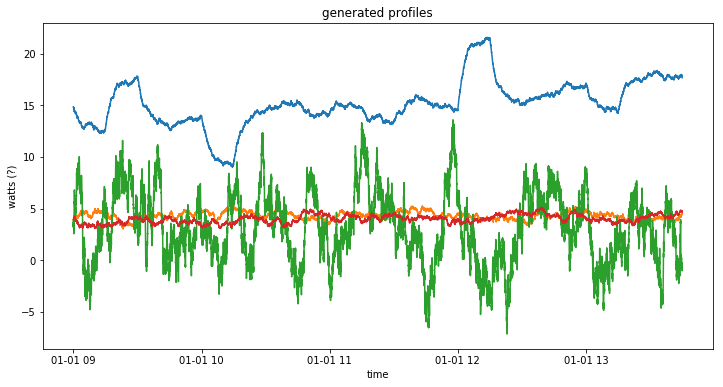

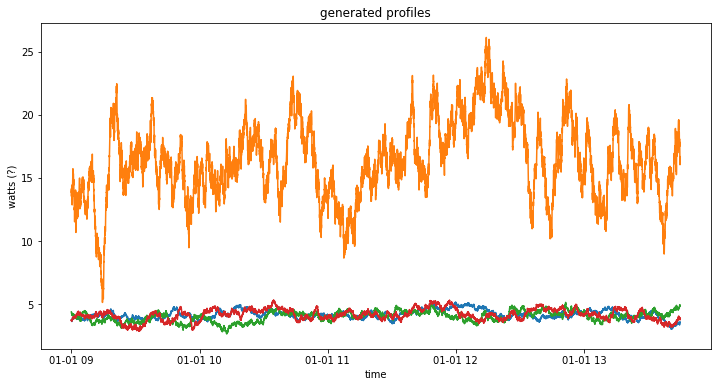

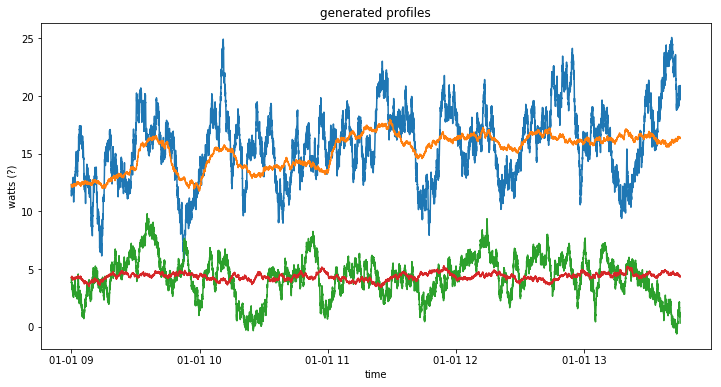

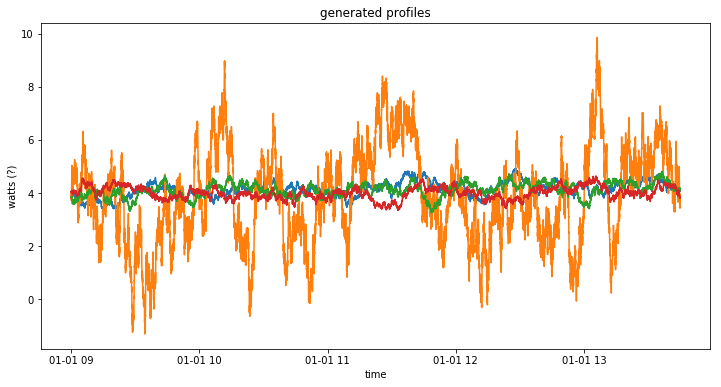

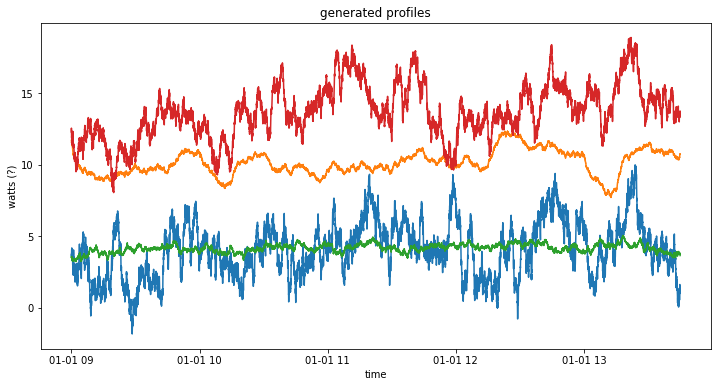

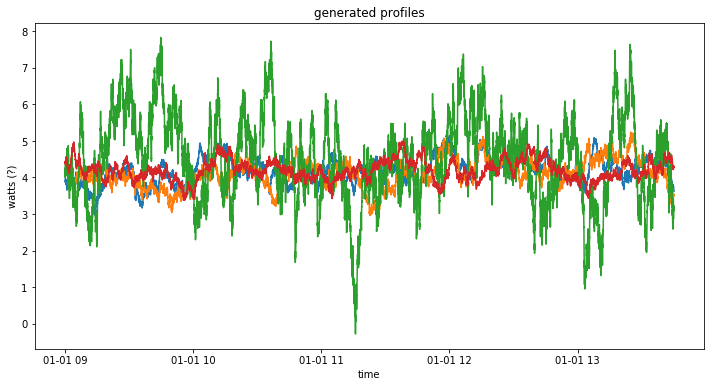

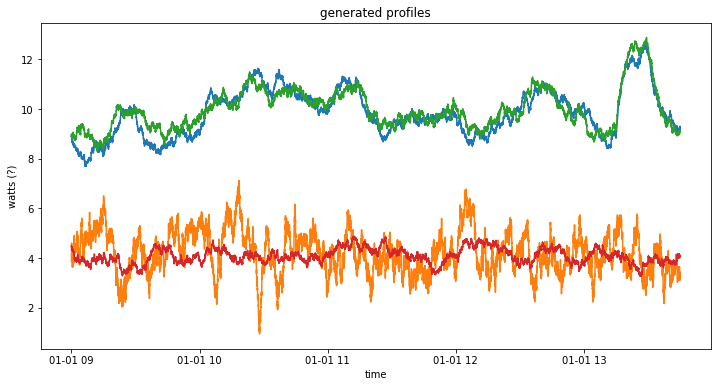

In [29]:
file_names = os.listdir("C:\\Users\\kathl\Desktop\\Github\\ceds-cigar\\pycigar\\utils\\data_generation\\load\\data\\LS\\")
data_prefix = "C:\\Users\\kathl\Desktop\\Github\\ceds-cigar\\pycigar\\utils\\data_generation\\load\\data\\LS\\"
len(file_names)
for i in range(0, len(file_names)//30, 4):
    curr_files = []
    for j in range(0, 4):
        curr_files.append(data_prefix + file_names[i + j])
   
    load_gen = LoadGenerator(curr_files, [])
    hi = load_gen.generate_load(order)

    fig = plt.figure(figsize=(12,6))
    for h in hi:
        plt.plot(h)
        #print(h.isnull().sum())
    plt.title('generated profiles')
    plt.xlabel('time')
    plt.ylabel('watts (?)')

In [17]:
import opendssdirect as dss
import os
from pycigar.utils.data_generation.load import LoadGenerator

#file_names = os.listdir('/home/toanngo/Documents/GitHub/smart-inverter-adaptive-control/pycigar/data/701_5min_disag_noise/701/LS')
file_names = os.listdir("C:\\Users\\kathl\Desktop\\Github\\ceds-cigar\\pycigar\\data\\701_5min_disag_noise\\701\\LS")
#dss.run_command('Redirect /home/toanngo/Documents/GitHub/smart-inverter-adaptive-control/pycigar/data/701_5min_disag_noise/Master.dss')
dss.run_command("Redirect C:\\Users\\kathl\Desktop\\Github\\ceds-cigar\\pycigar\\data\\701_5min_disag_noise\\Master.dss")
load_df = dss.utils.loads_to_dataframe()
output_dir = '/home/toanngo/Documents/GitHub/smart-inverter-adaptive-control/pycigar/data/701_5min_disag_noise/701/LS_shorten'
output_dir = "C:\\Users\\kathl\Desktop\\Github\\ceds-cigar\\pycigar\\data\\701_5min_disag_noise\\701\\LS_shorten"
names = [name[:-4] for name in file_names]
file_names = file_names
batch = 5
name_data = names
load_data = []
total_round_batch = len(names)//batch
print(total_round_batch)
for i in range(total_round_batch):
    print(i, end=" ")                                                       
    batch_names = names[i*batch:i*batch+batch]
    batch_file_names = file_names[i*batch:i*batch+batch]
    batch_order = []
    for name in batch_names:
        batch_order.append(load_df.loc[name.lower()]['kW'])
    load_gen = LoadGenerator(['{}/{}'.format(output_dir, name) for name in batch_file_names], input_time='15T', output_time='1S', order=batch_order)
    load = load_gen.generate_load(batch_order)
    load_data.extend(load)
batch_names = names[(i+1)*batch:]
batch_file_names = file_names[(i+1)*batch:]
batch_order = []
for name in batch_names:
    batch_order.append(load_df.loc[name.lower()]['kW'])
load_gen = LoadGenerator(['{}/{}'.format(output_dir, name) for name in batch_file_names], input_time='15T', output_time='1S', order=batch_order)
load = load_gen.generate_load(batch_order)
load_data.extend(load)
print('done')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\kathl\\Desktop\\Github\\ceds-cigar\\pycigar\\data\\701_5min_disag_noise\\701\\LS'

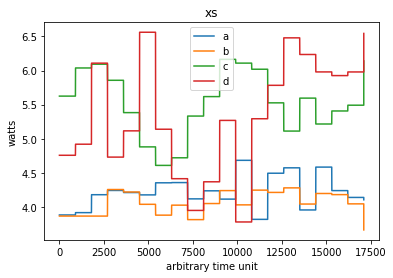

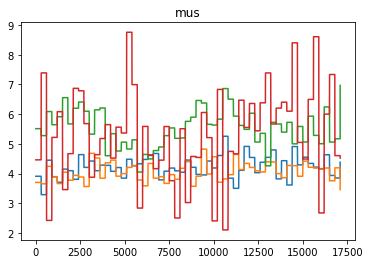

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
for a in load_gen.em_mu:
  
    plt.plot(a)
plt.legend(['a', 'b', 'c', 'd'])
plt.ylabel('watts')
plt.xlabel('arbitrary time unit')
plt.title('xs')
fig = plt.figure()
for b in load_gen.em_x:
    plt.plot(b)
plt.title('mus')
order = [4.67, 4.71, 4.76, 4.96]


Text(0, 0.5, 'watts (?)')

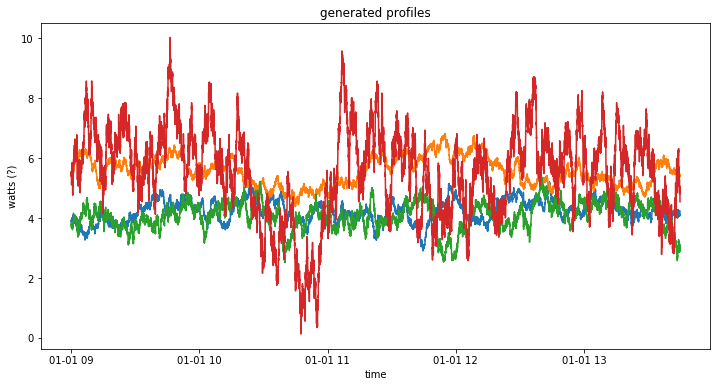

In [10]:
hi = load_gen.generate_load(order)

fig = plt.figure(figsize=(12,6))
for h in hi:
    plt.plot(h)
plt.title('generated profiles')
plt.xlabel('time')
plt.ylabel('watts (?)')

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep
from pycigar.utils.data_generation.load.src.cdf import make_cdf


def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get same start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc,
                     scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc,
                   scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


def normalize_data(time_series, order):
    pdfs = []
    pdf_std = []

    for file in time_series:
        # Make PDF with best params
        params = st.norm.fit(file)
      
        pdf = make_pdf(st.norm, params)  # mean and standard deviation
        pdf_std.append(params[1])
        pdfs.append(pdf)
        
    return pdfs, pdf_std


def generate_polynomial(pdfs, order, std_of_nonnormal_pdfs):
    """
    Fits a curve to standard deviation of the load profiles
    Saves this curve to a pickle file
    Plots curve
    """
    # must be ordered on x-coordinates to use splrep 
    zipped_lists = zip(order, std_of_nonnormal_pdfs)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
   
    spl = splrep(list1, list2)
    return spl

In [14]:

def read_initial_data(input_file, output_time):
    # Called by user
    """ 
    Returns contents of input CSV files as different output time sequences

    Args: 
    input_file (list of strings) - CSV file names 
        ex. ['7_MWp_P.csv', '10_MWp_P.csv', '12_MWp_P.csv', '19_MWp_P.csv']
    input_time (string) - Input time sequence 
        ex. '1S'
    output_time (list of strings)- Output time sequences 
        ex. ['1S', '10S', '30S']
    order (list of integers) -  MWp for each file 
        ex. [7, 10, 12, 19]

    """
    ff = []
    fdd = []
    tss = []
    for n in range(len(output_time)):
        f, ts = read_files(input_file, output_time[n])
        ff.append(f)
       
        tss.append(ts)
    return ff[0],tss[0]


def read_files(input_file, output_time):
    # User does not call

    """ 
    Reads the input CSV files and resamples/diffs
    Returns data in different forms

    Args: 
    input_file (list of strings) - CSV file names 
        ex. ['7_MWp_P.csv', '10_MWp_P.csv', '12_MWp_P.csv', '19_MWp_P.csv']
    output_time (list of strings)- Output time sequences 
        ex. ['1S', '10S', '30S']

    """
    file = [] # series from csv file
    file_diff = [] # resampled data
    time_series = [] # resampled data as a series

    for n in range(len(input_file)):
        file.append(pd.read_csv(input_file[n], index_col = 0, header = None,names=['P'], parse_dates=True ,infer_datetime_format=True))
#         print(file[n].resample(output_time).pad())
#         print(file[n].resample(output_time).mean().pad().diff(1))
        file_diff.append(file[n].resample(output_time).mean().pad().diff(1).dropna())
        
        time_series.append(file_diff[n].iloc[:,0])

    return file, time_series




def generate_mean_reversion_rate(files, output_time, input_time, order, spl):
    """
    Finds the mean reversion rate

    Args: 
    files (list of DataFrames)
    input_time (string) - represents in the input time series, ex. '1S'
    output_time (string) - represents the output time series, ex. '1S'
    order (list) - loading levels
    """

    # x(t) profile
    mrr = []
    em_mu = []
    em_x = []
    em_Y = []
    index_vals = []
    meaned_data = []
    orig_data = []

    for k in range(len(files)):
        #print(files[k].iloc[:10, :])
        xs = files[k].resample(output_time).mean().pad()
        meaned_data.append(xs)
        orig_data.append(files[k])
       

    for n in range(len(meaned_data)):
      
        mu = orig_data[n].resample(input_time, label='right').mean().resample(output_time).pad()
      #  print(len(mu), len(xs))
        print(mu)
        em_mu.append(mu)

        # x profile
        offset = len(xs) - len(mu)
        x = meaned_data[n].pad().iloc[:len(meaned_data[n])-offset, :]
   
        index_vals.append(x.index.array)
        em_x.append(x)

        # Forming the Y's (contingent on std_dev)
        Y = np.array([])
        np_x = x.to_numpy()
        np_mu_10 = mu.to_numpy()

        std_dev = splev(order[n], spl)
      

        for i in range(len(x)):
            Y = np.append(Y, (np_mu_10[i][0] - np_x[i][0]) / (std_dev**2))

        em_Y.append(Y)
     
        # Mean reversion rate
        num = 0
        denom = 0
        for j in range(len(x)-1):
            num += Y[j] * (np_x[j+1][0] - np_mu_10[j+1][0])
            denom += Y[j] * (np_x[j][0] - np_mu_10[j][0])
        mean_rev_rate = -np.log(num/denom)
        mrr.append(mean_rev_rate)

    for i in range(len(em_mu)):
        em_mu[i] = em_mu[i].to_numpy()
        em_x[i] = em_x[i].to_numpy()

    return mrr, em_mu, em_x, index_vals, meaned_data



In [15]:
ff,  tss = read_initial_data(new_file, ['1S'])
order = [4.67, 4.71, 4.76, 4.96]
output_time = '1S'
input_time = '15T'
#print(tss)
pdfs, std_of_nonnormal_pdfs = normalize_data(tss, order)
spl = generate_polynomial(pdfs, order, std_of_nonnormal_pdfs)

mrr, em_mu, em_x, index_vals, meaned_data = \
    generate_mean_reversion_rate(ff, output_time, input_time, order, spl)

                            P
2018-01-01 09:15:00  3.881310
2018-01-01 09:15:01  3.881310
2018-01-01 09:15:02  3.881310
2018-01-01 09:15:03  3.881310
2018-01-01 09:15:04  3.881310
...                       ...
2018-01-01 13:59:56  4.138520
2018-01-01 13:59:57  4.138520
2018-01-01 13:59:58  4.138520
2018-01-01 13:59:59  4.138520
2018-01-01 14:00:00  4.103869

[17101 rows x 1 columns]
                            P
2018-01-01 09:15:00  3.865012
2018-01-01 09:15:01  3.865012
2018-01-01 09:15:02  3.865012
2018-01-01 09:15:03  3.865012
2018-01-01 09:15:04  3.865012
...                       ...
2018-01-01 13:59:56  4.044175
2018-01-01 13:59:57  4.044175
2018-01-01 13:59:58  4.044175
2018-01-01 13:59:59  4.044175
2018-01-01 14:00:00  3.661899

[17101 rows x 1 columns]
                            P
2018-01-01 09:15:00  5.624873
2018-01-01 09:15:01  5.624873
2018-01-01 09:15:02  5.624873
2018-01-01 09:15:03  5.624873
2018-01-01 09:15:04  5.624873
...                       ...
2018-01-01 13:59:5

In [ ]:
# temp = ff[0].resample(input_time, label='right').mean().resample(output_time).pad()
# temp2 = temp.iloc[:, :]
# temp2.index.name = 'hey'
# print(temp2)
# temp3 = ff[0].resample(output_time).mean().pad()
# temp4 = temp3.iloc[600:, :]
# temp4.index.name = 'hi'

# temp4.iloc[300:, :]

In [ ]:
out = load_gen.generate_load(dss_kw)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
for i in out:
    plt.figure()
    plt.plot(i/10**6) #convert to watts
    
plt.show()